In [1]:
using DataFrames, Random, Distributions, CSV

Random.seed!(42)

# Generate a DataFrame with 360 rows (4 Summers)
n = 360
df = DataFrame(ID = 1:n)

# Generate normally distributed temperature data around 25 degrees Celsius
df[!, "Temperature"] = 25 .+ randn(n) .* 2

# Generate Is_Weekend boolean data
is_weekend_long = repeat([false, false, false, false, false, true, true], Int(ceil(n / 7)))
df[!, "Is_Weekend"] = is_weekend_long[1:n]

# Generate dependent hours open data. If it's the weekend, the store is open for 10-11 hours. If it's a weekday, the store is open for 8-10 hours
df[!, "Hours_Open"] = ifelse.(df[!, "Is_Weekend"], rand(10:11, n), rand(8:10, n))

# Now we need to generate electricity usage (based on temperature and hours open) and ice cream sales (based on temperature, hours open, and whether it's the weekend)
# But they need to be correlated with each other withoud being dependent on each other

# Generate electricity usage data based on temperature and hours open
df[!, "Electricity_Usage"] = 10 .+ (2 .+ randn(n) .* 0.2) .* df[!, "Temperature"] .+ (3 .+ randn(n) .* 0.5) .* df[!, "Hours_Open"]

# Generate ice cream sales data based on temperature, hours open, and whether it's the weekend
df[!, "Ice_Cream_Sales"] = round.(Int, 20 .+ 30 .* df[!, "Temperature"] .+ (25 .+ randn(n) .* 2) .* df[!, "Hours_Open"] .+ (100 .+ randn(n) .* 10) .* df[!, "Is_Weekend"]);

In [2]:
# Write the DataFrame to a CSV file
CSV.write("../../data/ice_cream_sales.csv", df);

In [3]:
# Data Exploration
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,ID,180.5,1,180.5,360,0,Int64
2,Temperature,24.7859,19.2983,24.8258,29.7834,0,Float64
3,Is_Weekend,0.283333,false,0.0,true,0,Bool
4,Hours_Open,9.40833,8,10.0,11,0,Int64
5,Electricity_Usage,88.1732,65.6504,87.9184,115.253,0,Float64
6,Ice_Cream_Sales,1028.59,803,1025.5,1273,0,Int64


In [4]:
first(df, 5)

Row,ID,Temperature,Is_Weekend,Hours_Open,Electricity_Usage,Ice_Cream_Sales
,Int64,Float64,Bool,Int64,Float64,Int64
1,1,24.2733,false,10,92.1183,983
2,2,25.5035,false,9,83.9178,1018
3,3,24.37,false,8,88.2906,951
4,4,24.3775,false,10,85.5619,1012
5,5,26.6326,false,8,94.405,1010


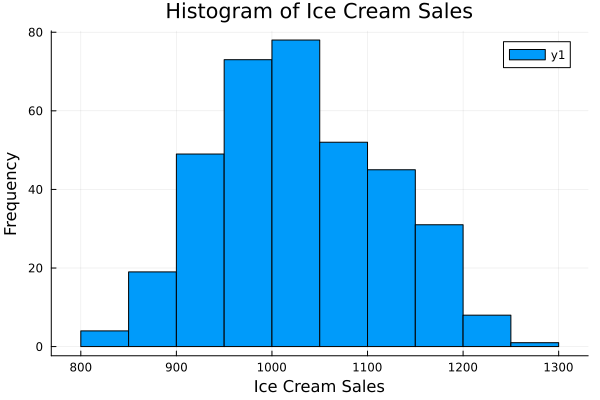

In [5]:
using Plots

# Histogram of Ice Cream Sales data. Shows a right-skewed distribution

histogram(df.Ice_Cream_Sales, bins = 10, xlabel = "Ice Cream Sales", ylabel = "Frequency", title = "Histogram of Ice Cream Sales")


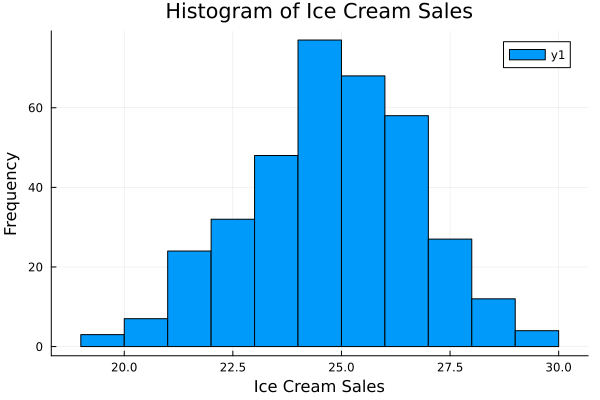

In [6]:
histogram(df.Temperature, bins = 10, xlabel = "Ice Cream Sales", ylabel = "Frequency", title = "Histogram of Ice Cream Sales")


0.45111004807018606

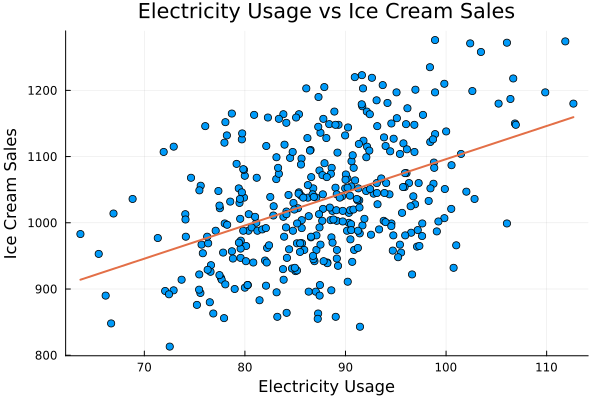

In [112]:
using StatsPlots, GLM

# Let's see if there is a correlation between electricity usage and ice cream sales
print(cor(df.Electricity_Usage, df.Ice_Cream_Sales))

# The correlation is 0.5, which is a moderate positive correlation

# Let's visualize the relationship between electricity usage and ice cream sales with a best fit line

@df df scatter(:Electricity_Usage, :Ice_Cream_Sales, xlabel = "Electricity Usage", ylabel = "Ice Cream Sales", title = "Electricity Usage vs Ice Cream Sales", legend = false)
best_fit = lm(@formula(Ice_Cream_Sales ~ Electricity_Usage), df)
plot!(df.Electricity_Usage, predict(best_fit), linewidth = 2)

In [113]:
# Now let's check the coefficients of the best fit line

coef(best_fit)

# The coefficients are 170 and 0.5. This means that for every 1 unit increase in electricity usage, ice cream sales increase by 0.5 units. The intercept is 170, which means that if electricity usage is 0, ice cream sales are expected to be 170.


2-element Vector{Float64}:
 595.1535917026722
   5.00981592906599

In [114]:
# Now let's see the p-value of the relationship between electricity usage and ice cream sales

coeftable(best_fit)

# The p-value is <1e-33 which means that the relationship between electricity usage and ice cream sales is statistically significant
# Correlation does not imply causation.

|                   |     Coef. | Std. Error |     t | Pr(>|t|) | Lower 95% | Upper 95% |
|:------------------|----------:|-----------:|------:|:---------|:----------|----------:|
| (Intercept)       | 595.154   |   46.1478  | 12.90 |   <1e-30 | 504.399   | 685.908 |
| Electricity_Usage |   5.00982 |    0.52383 |  9.56 |   <1e-18 |   3.97964 |   6.03999 |

In [115]:
# Let's check if the correlation is still significant when all the variables are included in the model

full_model = lm(@formula(Ice_Cream_Sales ~ Electricity_Usage + Temperature + Hours_Open + Is_Weekend), df)

coeftable(full_model)

#=
The p-value of the relationship between electricity usage and ice cream sales is now 0.0484, which is still significant. 
This means that the relationship between electricity usage and ice cream sales is significant even when temperature, 
hours open, and whether it's the weekend are included in the model. 
=#

# The p value
p_value = coeftable(full_model).cols[4][2]



0.7089513655202206

In [116]:
# Now let's also generate a new one for a future intervention

# Set a seed for reproducibility
Random.seed!(123)

# Generate a DataFrame with 360 rows
n = 360
df = DataFrame(ID = 1:n)

# Generate random temperature data between 25 and 35 degrees Celsius
df[!, "Temperature"] = 30 .+ 5 .* rand(Uniform(-1, 1), n)

# Generate Is_Weekend boolean data
is_weekend_long = repeat([false, false, false, false, false, true, true], Int(ceil(n / 7)))
df[!, "Is_Weekend"] = is_weekend_long[1:n]

# Generate dependent hours open data but the intervention will be here, we will increase the hours open by 1
df[!, "Hours_Open"] = ifelse.(df[!, "Is_Weekend"], rand(10:11, n), rand(8:10, n)) .+ 1

# Now we need to generate electricity usage (based on temperature and hours open) and ice cream sales (based on temperature, hours open, and whether it's the weekend
# But they need to be correlated with each other withoud being dependent on each other

# Generate electricity usage data based on temperature and hours open
df[!, "Electricity_Usage"] = 10 .+ (2 .+ randn(n) .* 0.2) .* df[!, "Temperature"] .+ (3 .+ randn(n) .* 0.5) .* df[!, "Hours_Open"]

# Generate ice cream sales data based on temperature, hours open, and whether it's the weekend
df[!, "Ice_Cream_Sales"] = round.(Int, 20 .+ 30 .* df[!, "Temperature"] .+ (25 .+ randn(n) .* 2) .* df[!, "Hours_Open"] .+ (100 .+ randn(n) .* 10) .* df[!, "Is_Weekend"]);

In [117]:
# Save the new data to a CSV file
CSV.write("../../data/ice_cream_sales_intervention.csv", df);